In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


df=pd.read_csv('bangalore_rain2.csv')
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
#Bring 'Rain(mm)' to first axis
rain = df['Rain(mm)']
df.drop(labels=['Rain(mm)'], axis=1,inplace = True)
df.insert(0, 'Rain(mm)', rain)
df_new=pd.DataFrame(df.iloc[:,0])
df_new.head()

,Rain(mm)
Date,
2018-01-01,0.0
2018-01-02,0.0
2018-01-03,0.2
2018-01-04,0.0
2018-01-05,0.0


In [2]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df.drop(columns=['date'],inplace=True)
    return df

In [3]:
df_new=create_features(df_new)
df_final=pd.get_dummies(df_new, columns=['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear'])
df_final.tail()

,Rain(mm),dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,...,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-31,4.0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-01,7.3,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-02,15.6,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-03,1.7,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-06-04,24.7,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Remove outliers
def outlier_adjustment_iqr(df,col,outlierConstant=1.5):
    a=df[col].values
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    resultset=[]
    for item in a:
        if item >= quartileSet[0] and item <= quartileSet[1]:
            resultset.append(item)
    
    mu=np.mean(resultset)
            
    for y in a:
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
        elif y<quartileSet[0]:
            resultList.append(0)
        elif y>quartileSet[1]:
            resultList.append(mu)
    df[col]=resultList
    return df

df_final=outlier_adjustment_iqr(df_final,'Rain(mm)',outlierConstant=1.5)

In [5]:
#Split Data for training and validation
trainX, trainY = df_final.iloc[:-365,1:],df_final.iloc[:-365,0]
testX, testY=df_final.iloc[-365:,1:],df_final.iloc[-365:,0]
train, labels = df_final.iloc[:,1:],df_final.iloc[:,0]

print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(517, 474) (517,) (365, 474) (365,)


In [6]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [7]:
model.fit(trainX,trainY)
predictions=model.predict(testX)

In [8]:
df_test=pd.DataFrame(testY)
df_predict=pd.DataFrame(predictions,index=df_test.index,columns=['Prediction'])
df_predict['Prediction']=[0.0 if w<0 else w for w in df_predict['Prediction'].values]

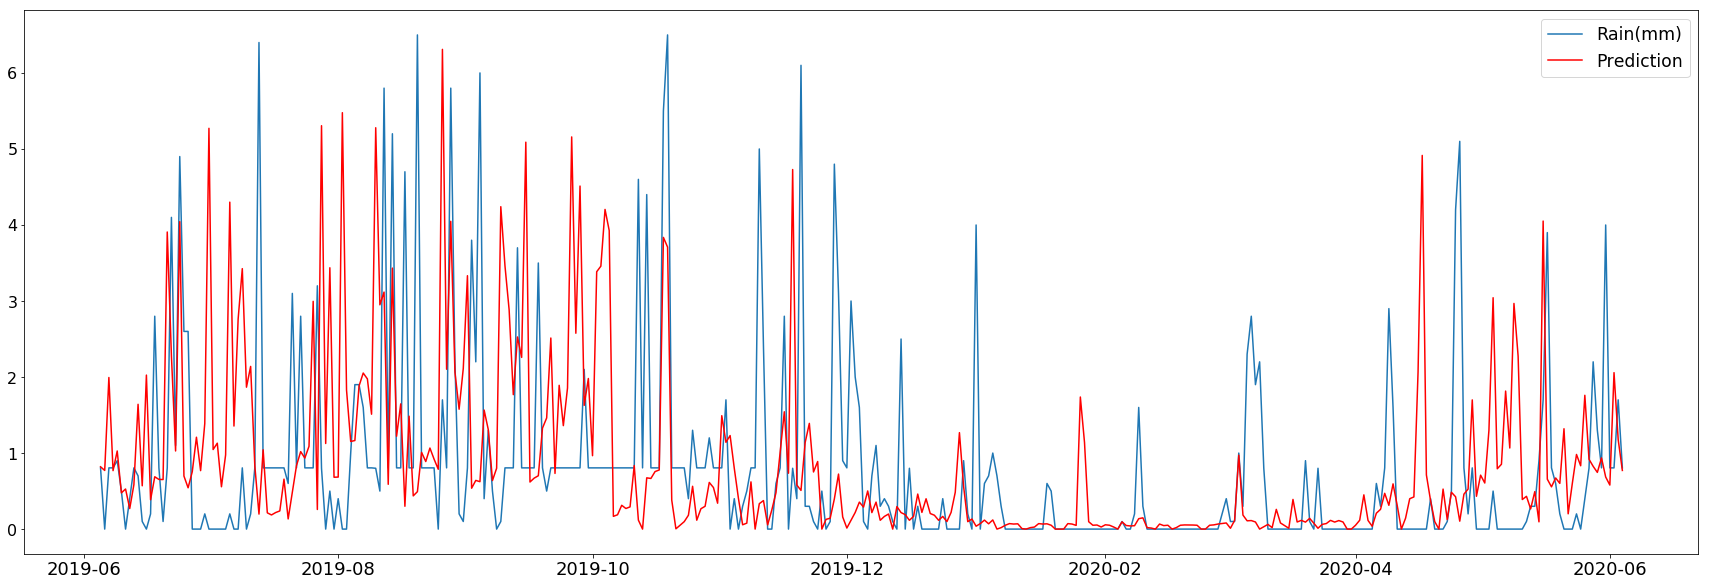

In [9]:
plt.figure(figsize=(30, 10))
plt.plot(df_test.index, df_test['Rain(mm)'])
plt.plot(df_test.index, df_predict['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [10]:
#Add future dates
n_input = 45
from pandas.tseries.offsets import DateOffset
add_dates = [df_new.index[-1] + DateOffset(days=x) for x in range(0,n_input+1) ]
future_dates = pd.DataFrame(index=add_dates[1:])
future_dates=create_features(future_dates)
future_dates=pd.get_dummies(future_dates, columns=['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear'])
future_dates.head()

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_2,quarter_3,month_6,...,dayofmonth_28,dayofmonth_29,dayofmonth_30,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_28,weekofyear_29
2020-06-05,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2020-06-06,0,0,0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2020-06-07,0,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2020-06-08,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2020-06-09,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [11]:
#add extra columns of training data
for col in train.columns:
    if col not in future_dates.columns:
        future_dates[col]=0

In [12]:
#Rearrange column order for train and future_dates
new_col_order=train.columns.sort_values()
future_dates=future_dates[new_col_order]
train=train[new_col_order]
new_col_order

Index(['dayofmonth_1', 'dayofmonth_10', 'dayofmonth_11', 'dayofmonth_12',
       'dayofmonth_13', 'dayofmonth_14', 'dayofmonth_15', 'dayofmonth_16',
       'dayofmonth_17', 'dayofmonth_18',
       ...
       'weekofyear_50', 'weekofyear_51', 'weekofyear_52', 'weekofyear_6',
       'weekofyear_7', 'weekofyear_8', 'weekofyear_9', 'year_2018',
       'year_2019', 'year_2020'],
      dtype='object', length=474)

In [13]:
model_predict = xgb.XGBRegressor()
model_predict.fit(train,labels)
prediction_future=model_predict.predict(future_dates)

In [14]:
#Create dataframe with prediction
df_predict_future=pd.DataFrame(prediction_future,index=future_dates.index,columns=['Future Prediction'])
df_past=pd.DataFrame(labels.values,index=labels.index,columns=['Past Data'])
df_concated=pd.concat([df_predict_future,df_past])

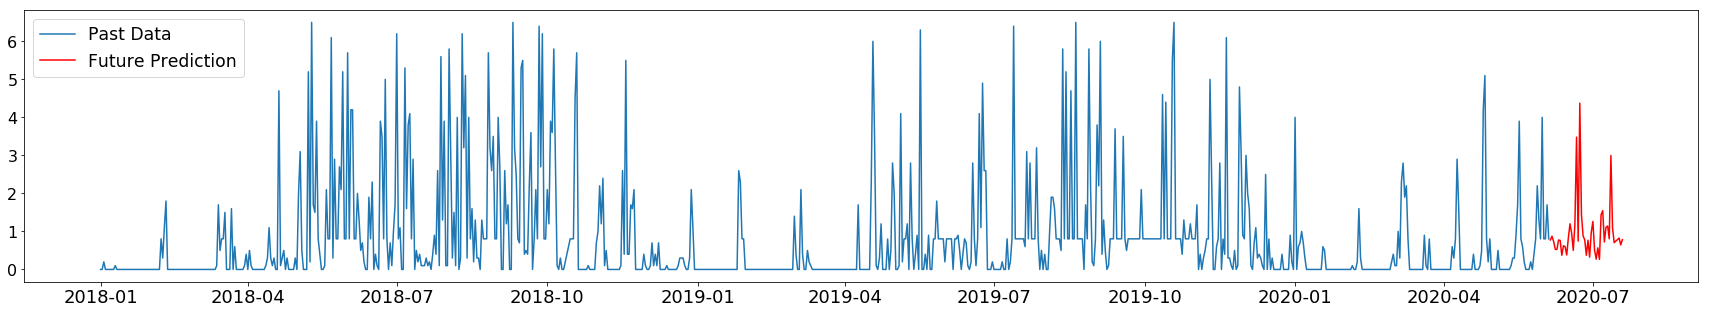

In [16]:
plt.figure(figsize=(30, 5))
plt.plot(df_concated.index, df_concated['Past Data'])
plt.plot(df_concated.index, df_concated['Future Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()